# Data Cleaning and EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# load datasets
ratings = pd.read_csv("./ratings.csv")
movies = pd.read_csv("./movies.csv")
tags = pd.read_csv("./tags.csv")
links = pd.read_csv("./links.csv")

# snapshot of dfs
def snapshot(df, name):
    print(f"\n=== {name.upper()} ===")
    print("\nFirst 10 rows:")
    print(df.head(10))
    print("\nInfo / dtypes:")
    print(df.info(memory_usage='deep'))
    print("\nNull counts:")
    print(df.isnull().sum())
    print("\nBasic stats (numeric):")
    print(df.describe(include='all').transpose())

In [4]:
# snapshots
snapshot(ratings, "ratings")
snapshot(movies, "movies")
snapshot(tags, "tags")
snapshot(links, "links")


=== RATINGS ===

First 10 rows:
   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
5       1       34     2.0  943228491
6       1       36     1.0  944249008
7       1       80     5.0  944248943
8       1      110     3.0  943231119
9       1      111     5.0  944249008

Info / dtypes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None

Null counts:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Basic stats (numeric):
                count          mean           std          min           25%  \
userId     32000204.0  1.00

In [5]:
# rename features in ratings
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})

In [6]:
# drop minor na rows in tags
tags = tags.dropna(subset=['tag'])

In [7]:
# drop 17 na rows in links
links = links.dropna(subset=['tmdbId'])

In [8]:
# count users with less than 20 ratings
user_rating_counts = ratings.groupby('user').size()
users_less_than_20 = (user_rating_counts < 20).sum()

print(f"Number of users with less than 20 ratings: {users_less_than_20:,}")
print(f"Percentage of users with less than 20 ratings: {users_less_than_20 / len(user_rating_counts) * 100:.2f}%")
print(f"Total number of users: {len(user_rating_counts):,}")

Number of users with less than 20 ratings: 0
Percentage of users with less than 20 ratings: 0.00%
Total number of users: 200,948


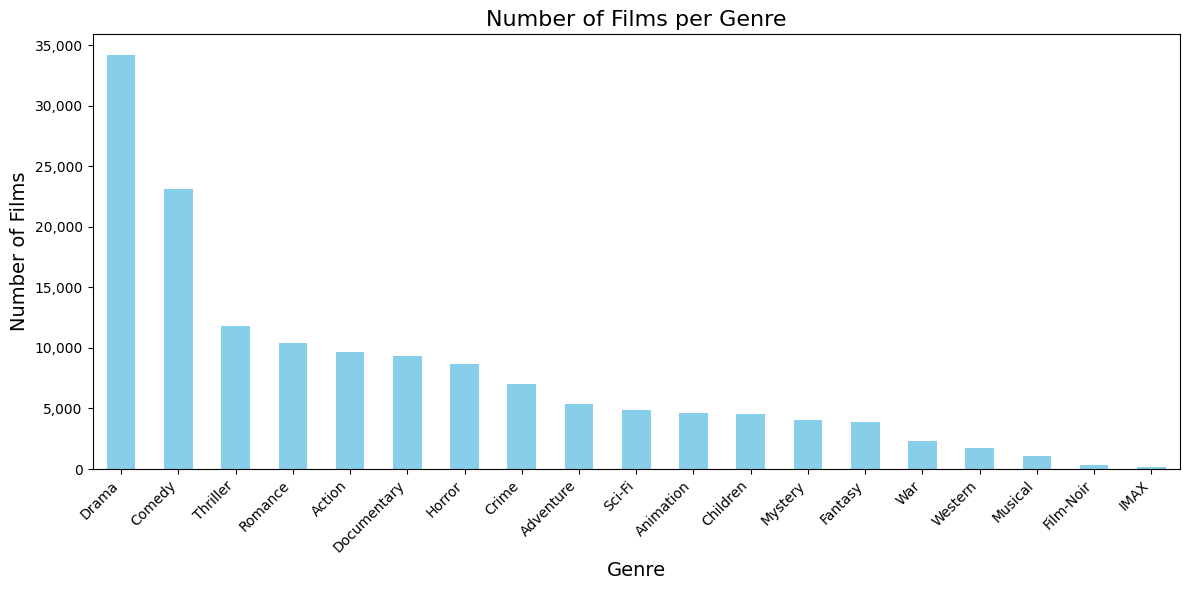

In [9]:
# Split pipe-separated genres and count them
genre_counts = pd.Series([genre for genres_string in movies['genres'] 
                         for genre in genres_string.split('|') 
                         if genre.strip() != '(no genres listed)']).value_counts()

plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Films per Genre', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Films', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.tight_layout()
plt.savefig('Figure_1.png')
plt.show()

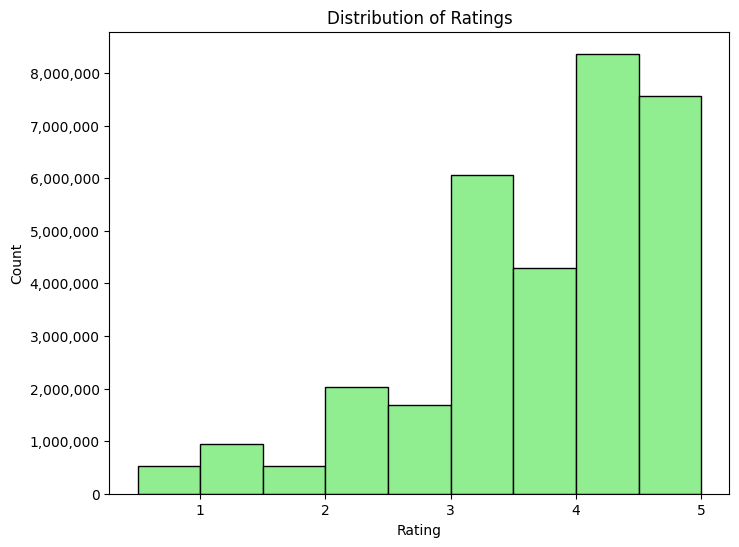

In [ ]:
# plot for distribution of ratings
plt.figure(figsize=(8,6))
ratings['rating'].hist(bins=9, color='lightgreen', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(False)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.savefig('Figure_2.png')
plt.show()

# Model Tuning 

In [7]:
import numpy as np
import pandas as pd

from lenskit.crossfold import partition_users, SampleN
from lenskit.algorithms.als import BiasedMF
from lenskit.topn import RecListAnalysis, ndcg, precision, recall

# ----- knobs you can tweak -----
N_USERS_SAMPLE  = 100_000   # dev subset; set None to use all users
HOLDOUT_N       = 5        # per-user holdout size
MF_FEATURES     = 64
MF_ITERATIONS   = 20
MF_REG          = 0.01
MF_DAMPING      = 2.0
N_RECS          = 10       # Top-N for metrics
ALPHA_BLEND     = 0.5      # similarity vs predicted-rating blend
TOPK_SIM        = 500      # seed-sim candidate pool (smaller = faster)
MAX_USERS_EVAL  = 10_000    # evaluate on at most this many users
RANDOM_SEED     = 42

np.random.seed(RANDOM_SEED)

In [8]:
if N_USERS_SAMPLE is not None:
    sampled = ratings['user'].drop_duplicates().sample(N_USERS_SAMPLE, random_state=RANDOM_SEED)
    ratings_eval = ratings[ratings['user'].isin(sampled)].reset_index(drop=True)
else:
    ratings_eval = ratings.copy()

print(f"Eval set — ratings: {len(ratings_eval):,} | users: {ratings_eval['user'].nunique():,}")

Eval set — ratings: 15,862,218 | users: 100,000


In [9]:
splits = list(partition_users(
    ratings_eval[['user','item','rating']],
    partitions=1,
    method=SampleN(HOLDOUT_N),
    rng_spec=RANDOM_SEED
))
train, test = splits[0]

print("Train:", train.shape, "| users:", train['user'].nunique())
print("Test :", test.shape , "| users:", test['user'].nunique())

Train: (15362218, 3) | users: 100000
Test : (500000, 3) | users: 100000


In [10]:
mf = BiasedMF(features=MF_FEATURES, iterations=MF_ITERATIONS, reg=MF_REG, damping=MF_DAMPING)
mf.fit(train[['user','item','rating']])
print("MF trained.")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


MF trained.


In [11]:
# Item factors & index
P = mf.item_features_
item_index = mf.item_index_
itemid_to_row = {iid: i for i, iid in enumerate(item_index.values)}

# Normalize rows for cosine
norms = np.linalg.norm(P, axis=1, keepdims=True); norms[norms==0]=1.0
P_norm = P / norms

def similar_items_cosine(seed_item, topk=TOPK_SIM):
    if seed_item not in itemid_to_row:
        return np.array([], dtype=np.int64), np.array([], dtype=np.float32)
    sidx = itemid_to_row[seed_item]
    sims = P_norm @ P_norm[sidx]
    sims[sidx] = -1.0
    if topk >= sims.size:
        top_idx = np.argsort(-sims)
    else:
        top_idx = np.argpartition(-sims, topk)[:topk]
        top_idx = top_idx[np.argsort(-sims[top_idx])]
    return item_index.values[top_idx], sims[top_idx]

In [12]:
def recommend_with_seed_fast(user, seed_item, n=N_RECS, alpha=ALPHA_BLEND, topk_sim=TOPK_SIM, seen=None):
    # candidate pool via seed similarity
    cand_items, sim_scores = similar_items_cosine(seed_item, topk=topk_sim)
    if len(cand_items) == 0:
        return None

    # filter seen + seed
    if seen:
        mask = ~np.isin(cand_items, list(seen | {seed_item}))
        cand_items = cand_items[mask]; sim_scores = sim_scores[mask]
        if len(cand_items) == 0:
            return None

    # vectorized predicted ratings for this user
    preds = mf.predict_for_user(user, cand_items)           # Series
    preds = preds.reindex(cand_items).to_numpy(dtype=np.float32)

    # blended score
    scores = alpha * sim_scores + (1.0 - alpha) * preds
    k = min(n, len(scores))
    top_idx = np.argpartition(-scores, k-1)[:k]
    top_idx = top_idx[np.argsort(-scores[top_idx])]
    return pd.DataFrame({'user': user, 'item': cand_items[top_idx], 'score': scores[top_idx]})

In [13]:
# Choose eval users (cap for speed)
eval_users = pd.Index(test['user'].unique())
if MAX_USERS_EVAL is not None and len(eval_users) > MAX_USERS_EVAL:
    eval_users = eval_users.to_series().sample(MAX_USERS_EVAL, random_state=RANDOM_SEED).to_numpy()

# seen items (train) and a fast seed per user (argmax rating)
user_seen = train.groupby('user', observed=True)['item'].agg(lambda s: set(s.values))
idx_max = train.groupby('user')['rating'].idxmax()
seed_per_user = train.loc[idx_max].set_index('user')['item']

# Generate recs
all_recs = []
for i, u in enumerate(eval_users, 1):
    seed = seed_per_user.get(u, None)
    if pd.isna(seed) or seed not in itemid_to_row:
        continue
    rec_df = recommend_with_seed_fast(u, seed, n=N_RECS, alpha=ALPHA_BLEND, topk_sim=TOPK_SIM, seen=user_seen.get(u, set()))
    if rec_df is not None and not rec_df.empty:
        all_recs.append(rec_df)
    if i % 200 == 0:
        print(f"Processed {i} users…")

recs = pd.concat(all_recs, ignore_index=True) if all_recs else pd.DataFrame(columns=['user','item','score'])
print("Recs:", recs.shape)
recs.head()

Processed 200 users…
Processed 400 users…
Processed 600 users…
Processed 800 users…
Processed 1000 users…
Processed 1200 users…
Processed 1400 users…
Processed 1600 users…
Processed 1800 users…
Processed 2000 users…
Processed 2200 users…
Processed 2400 users…
Processed 2600 users…
Processed 2800 users…
Processed 3000 users…
Processed 3200 users…
Processed 3400 users…
Processed 3600 users…
Processed 3800 users…
Processed 4000 users…
Processed 4200 users…
Processed 4400 users…
Processed 4600 users…
Processed 4800 users…
Processed 5000 users…
Processed 5200 users…
Processed 5400 users…
Processed 5600 users…
Processed 5800 users…
Processed 6000 users…
Processed 6200 users…
Processed 6400 users…
Processed 6600 users…
Processed 6800 users…
Processed 7000 users…
Processed 7200 users…
Processed 7400 users…
Processed 7600 users…
Processed 7800 users…
Processed 8000 users…
Processed 8200 users…
Processed 8400 users…
Processed 8600 users…
Processed 8800 users…
Processed 9000 users…
Processed 9200

,user,item,score
0,152689,3114,2.996019
1,152689,151703,2.889237
2,152689,244832,2.866733
3,152689,283577,2.853547
4,152689,143059,2.800801


In [14]:
# Choose eval users (cap for speed)
eval_users = pd.Index(test['user'].unique())
if MAX_USERS_EVAL is not None and len(eval_users) > MAX_USERS_EVAL:
    eval_users = eval_users.to_series().sample(MAX_USERS_EVAL, random_state=RANDOM_SEED).to_numpy()

# seen items (train) and a fast seed per user (argmax rating)
user_seen = train.groupby('user', observed=True)['item'].agg(lambda s: set(s.values))
idx_max = train.groupby('user')['rating'].idxmax()
seed_per_user = train.loc[idx_max].set_index('user')['item']

# Generate recs
all_recs = []
for i, u in enumerate(eval_users, 1):
    seed = seed_per_user.get(u, None)
    if pd.isna(seed) or seed not in itemid_to_row:
        continue
    rec_df = recommend_with_seed_fast(u, seed, n=N_RECS, alpha=ALPHA_BLEND, topk_sim=TOPK_SIM, seen=user_seen.get(u, set()))
    if rec_df is not None and not rec_df.empty:
        all_recs.append(rec_df)
    if i % 200 == 0:
        print(f"Processed {i} users…")

recs = pd.concat(all_recs, ignore_index=True) if all_recs else pd.DataFrame(columns=['user','item','score'])
print("Recs:", recs.shape)
recs.head()

Processed 200 users…
Processed 400 users…
Processed 600 users…
Processed 800 users…
Processed 1000 users…
Processed 1200 users…
Processed 1400 users…
Processed 1600 users…
Processed 1800 users…
Processed 2000 users…
Processed 2200 users…
Processed 2400 users…
Processed 2600 users…
Processed 2800 users…
Processed 3000 users…
Processed 3200 users…
Processed 3400 users…
Processed 3600 users…
Processed 3800 users…
Processed 4000 users…
Processed 4200 users…
Processed 4400 users…
Processed 4600 users…
Processed 4800 users…
Processed 5000 users…
Processed 5200 users…
Processed 5400 users…
Processed 5600 users…
Processed 5800 users…
Processed 6000 users…
Processed 6200 users…
Processed 6400 users…
Processed 6600 users…
Processed 6800 users…
Processed 7000 users…
Processed 7200 users…
Processed 7400 users…
Processed 7600 users…
Processed 7800 users…
Processed 8000 users…
Processed 8200 users…
Processed 8400 users…
Processed 8600 users…
Processed 8800 users…
Processed 9000 users…
Processed 9200

,user,item,score
0,152689,3114,2.996019
1,152689,151703,2.889237
2,152689,244832,2.866733
3,152689,283577,2.853547
4,152689,143059,2.800801


In [15]:
from lenskit.topn import RecListAnalysis, ndcg, precision, recall
rla = RecListAnalysis()
rla.add_metric(ndcg)
rla.add_metric(precision)
rla.add_metric(recall)

metrics_per_user = rla.compute(
    recs[['user','item']].copy(),
    test[['user','item','rating']].copy()
)

# F1 from P & R
den = (metrics_per_user['precision'] + metrics_per_user['recall']).replace(0, np.nan)
metrics_per_user['f1'] = 2 * (metrics_per_user['precision'] * metrics_per_user['recall']) / den
metrics_per_user['f1'] = metrics_per_user['f1'].fillna(0.0)

overall = metrics_per_user[['ndcg','precision','recall','f1']].mean().to_frame('mean').T
display(overall)

print(f"Top-{N_RECS}  | nDCG: {overall.ndcg.values[0]:.4f}  "
      f"| Precision: {overall.precision.values[0]:.4f}  "
      f"| Recall: {overall.recall.values[0]:.4f}  "
      f"| F1: {overall.f1.values[0]:.4f}")

,ndcg,precision,recall,f1
mean,0.010887,0.00593,0.01186,0.007907


Top-10  | nDCG: 0.0109  | Precision: 0.0059  | Recall: 0.0119  | F1: 0.0079


# CF Model Building

In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from lenskit.algorithms.als import BiasedMF

In [17]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
ratings.head()

,user,item,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [19]:
np.random.seed(42)
# convert to lighter types for training 
ratings['user']   = ratings['user'].astype(np.int32)
ratings['item']   = ratings['item'].astype(np.int32)
ratings['rating'] = ratings['rating'].astype(np.float32)

# train BiasedMF (ALS) with better parameters
print("🤖 Training model...")
mf = BiasedMF(features=64, iterations=20, damping=2, reg=0.01) 
mf.fit(ratings[['user','item','rating']])


🤖 Training model...


In [20]:
# extract item (movie) factor matrix
P = getattr(mf, "item_features_", None)
if P is None:
    raise RuntimeError(f"Model has no 'item_features_'. Keys: {sorted(mf.__dict__.keys())}")

P = P.toarray().astype(np.float32) if hasattr(P, "toarray") else np.asarray(P, dtype=np.float32)

# extract item index
def first_attr(obj, names):
    for n in names:
        if hasattr(obj, n):
            val = getattr(obj, n)
            if val is not None:
                return val
    return None

item_index = first_attr(mf, ["item_index_", "item_index", "items_"])
if item_index is None:
    raise RuntimeError(f"Could not find item index on model. Keys: {sorted(mf.__dict__.keys())}")

# normalize to a series mapping row -> movieId
if hasattr(item_index, "to_series"):
    idx_to_item = item_index.to_series()
elif isinstance(item_index, pd.Index):
    idx_to_item = pd.Series(item_index.to_numpy(), index=np.arange(len(item_index)))
elif isinstance(item_index, (list, np.ndarray)):
    idx_to_item = pd.Series(np.asarray(item_index), index=np.arange(len(item_index)))
else:
    idx_to_item = pd.Series(np.array(list(item_index)), index=np.arange(len(item_index)))

# Sanity check
assert P.shape[0] == len(idx_to_item), f"Mismatch: P rows {P.shape[0]} vs index {len(idx_to_item)}"

print("Item factors shape:", P.shape)
print("Index length:", len(idx_to_item))


Item factors shape: (84432, 64)
Index length: 84432


In [21]:
# normalize item vectors for cosine similarity
P_norm = P / (np.linalg.norm(P, axis=1, keepdims=True) + 1e-12)

# find title of movie, prioritizing exact match, then closest
def find_movie_ids_by_title(title_query, movies_df, k=10):
    q = title_query.strip().lower()
    hits  = movies_df[movies_df['title'].str.lower().str.contains(q, na=False)]
    exact = movies_df[movies_df['title'].str.lower() == q]
    if not exact.empty:
        hits = pd.concat([exact, hits.loc[~hits.index.isin(exact.index)]], axis=0)
    return hits.head(k)[['movieId','title','genres']].reset_index(drop=True)

# build lookup: item id -> row index in P_norm
item_to_row = {int(idx_to_item.iloc[i]): i for i in range(len(idx_to_item))}

# find cosine similarity between candidate and all movies
def similar_items_mf(seed_item_id: int, n: int = 10) -> pd.DataFrame:
    row = item_to_row.get(int(seed_item_id))
    if row is None:
        raise ValueError(f"Item {seed_item_id} not in MF model.")
    sims = P_norm @ P_norm[row]     # cosine with every item
    sims[row] = -np.inf             # drop self
    top = np.argpartition(-sims, kth=min(n, sims.size-1))[:n]
    top = top[np.argsort(-sims[top])]
    out = pd.DataFrame({
        'movieId': [int(idx_to_item.iloc[i]) for i in top],
        'score': sims[top]
    })
    return out.merge(movies[['movieId','title','genres']], on='movieId', how='left')

# call function to find candidate movie, call function to find cosine similarities, return recs
def similar_by_title_mf(title_query: str, n: int = 10, choose_idx: int = 0):
    cand = find_movie_ids_by_title(title_query, movies, k=10)
    if cand.empty:
        raise ValueError(f"No matches for '{title_query}'")
    seed = int(cand.iloc[choose_idx]['movieId'])
    recs = similar_items_mf(seed, n=n)
    return seed, cand, recs

In [22]:
# test example
seed_id, choices, recs = similar_by_title_mf("Inception", n=10)
print(choices) 
print(recs.head(10))

   movieId             title                                           genres
0    79132  Inception (2010)  Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
   movieId     score                           title  \
0   109487  0.575125             Interstellar (2014)   
1   217465  0.562571                    Tenet (2020)   
2    74458  0.531389           Shutter Island (2010)   
3    48780  0.519171            Prestige, The (2006)   
4   268522  0.482609           Four to Dinner (2022)   
5   253724  0.471627               Summertime (2020)   
6   226302  0.464540  Tulpa - Demon of Desire (2012)   
7   175391  0.463103           I, Pet Goat II (2012)   
8   154804  0.459223       Nostos: The Return (1989)   
9   157817  0.453078           Ruin Explorers (1995)   

                          genres  
0                    Sci-Fi|IMAX  
1                Action|Thriller  
2         Drama|Mystery|Thriller  
3  Drama|Mystery|Sci-Fi|Thriller  
4                 Comedy|Romance  
5                

In [23]:
# save (model + factors & mapping)
ART = Path("artifacts"); ART.mkdir(parents=True, exist_ok=True)
joblib.dump(mf, ART / "mf_biased.joblib")
np.save(ART / "mf_item_factors.npy", P_norm)             
idx_to_item.to_csv(ART / "mf_item_index.csv", index=True)  
print("✅ Saved MF artifacts in", ART)

✅ Saved MF artifacts in artifacts
